<a href="https://colab.research.google.com/github/markjschmidt/PET_List/blob/main/MJS_AI_PET_Ring_Circular_Visualization_revD2_20250628.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## MJS Anthropic AI PET Ring Circular Visualization

Edits to reduce plot size
Correct circular plots for full 360 degrees

Laptop file location: C:\Users\usd11318\Documents\Marks_Documents\Customers\SLU\Vereos\List_Format_Data\QA_Src_at_Bottom


Upload the src_at_bottom_24934.txt file:


Saving src_at_bottom_24934.txt to src_at_bottom_24934.txt
Successfully processed the file. Created a DataFrame with 1093 rows.

--- Basic Statistics ---
xa: Min = 0, Max = 453
xb: Min = 108, Max = 575

Creating paired events visualization...


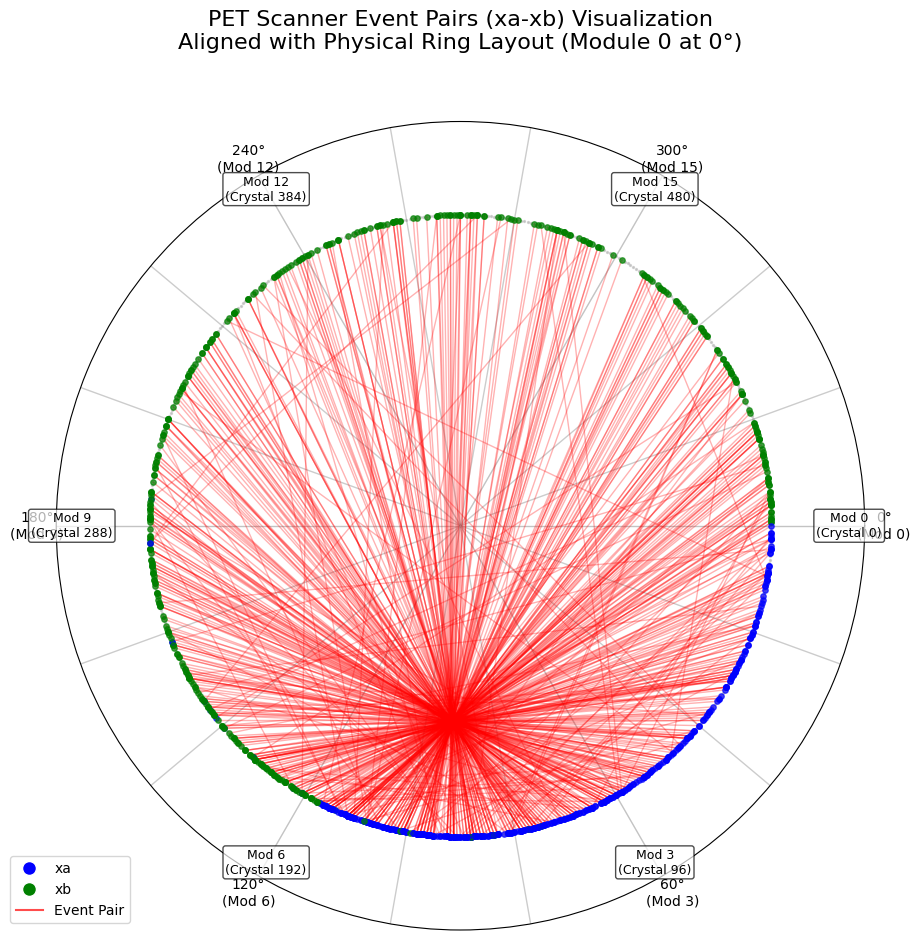


Creating heatmap...


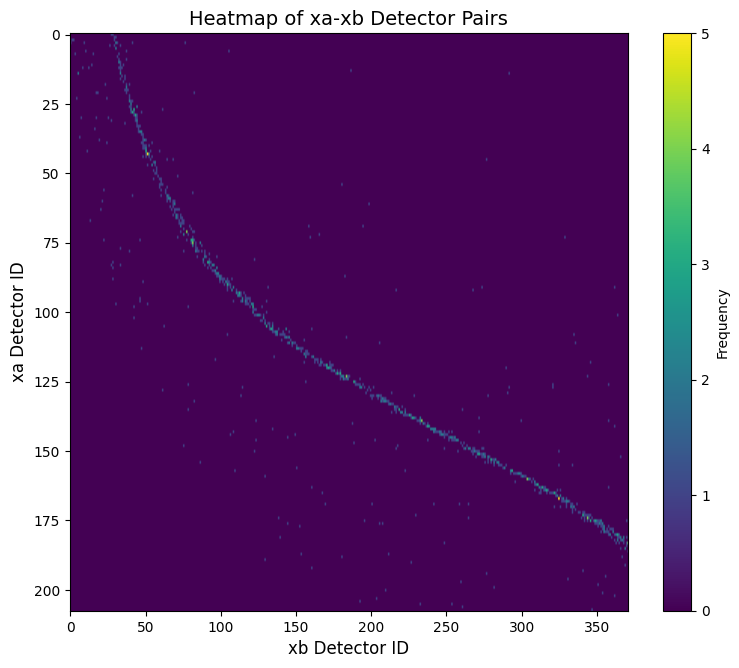


Both visualizations complete with fixes applied!


In [ ]:
# Fixed PET Ring Circular Visualization
# Creates circular plots showing the distribution of xa and xb values in a Vereos PET scanner

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px
import re
from google.colab import files
import plotly.io as pio

# Enable Plotly in Colab
pio.renderers.default = 'colab'

# Function to extract values from parentheses for each metric
def extract_values(line):
    pattern = r'xa\((\d+)\) xb\((\d+)\) tof\(([-]?\d+)\) za\((\d+)\) zb\((\d+)\)'
    match = re.search(pattern, line)
    if match:
        return {
            'xa': int(match.group(1)),
            'xb': int(match.group(2)),
            'tof': int(match.group(3)),
            'za': int(match.group(4)),
            'zb': int(match.group(5))
        }
    return None

# Function to process file content
def process_file_content(file_content):
    data_list = []

    for line in file_content.split('\n'):
        # Check if line contains PROMPT or DELAY and the required data
        if ('PROMPT:' in line or 'DELAY:' in line) and 'xa(' in line:
            values = extract_values(line)
            if values:
                data_list.append(values)

    # Create DataFrame
    df = pd.DataFrame(data_list)
    return df

# Function to visualize paired xa and xb positions (FIXED VERSION)
def create_paired_events_plot(df):
    # Create a sample of events to visualize (to avoid overcrowding)
    sample_size = min(500, len(df))
    sample_df = df.sample(sample_size, random_state=42)

    # FIXED: Proper angle calculation that ensures full circle coverage
    # Convert crystal IDs directly to polar coordinates (theta in radians)
    # Crystal 0 is at top (90°), and increases clockwise
    sample_df['xa_theta'] = (sample_df['xa'] * 2 * np.pi / 576)
    sample_df['xb_theta'] = (sample_df['xb'] * 2 * np.pi / 576)

    # Create figure with 75% of original size (was 14x14, now ~10.5x10.5)
    fig = plt.figure(figsize=(10.5, 10.5))
    ax = fig.add_subplot(111, polar=True)

    # FIXED: Create the complete detector ring with all 576 crystals
    # Generate theta values for all crystals (0 to 2π)
    all_crystal_theta = np.linspace(0, 2*np.pi, 576, endpoint=False)
    ax.scatter(all_crystal_theta, [1]*576, s=2, color='gray', alpha=0.3, zorder=1)

    # Plot event pairs with lines connecting xa and xb
    for idx, row in sample_df.iterrows():
        # Draw line connecting xa and xb
        ax.plot([row['xa_theta'], row['xb_theta']], [1, 1],
                color='red', alpha=0.3, linewidth=1, zorder=2)

        # Plot xa point
        ax.scatter(row['xa_theta'], 1, s=15, color='blue', alpha=0.7, zorder=3)

        # Plot xb point
        ax.scatter(row['xb_theta'], 1, s=15, color='green', alpha=0.7, zorder=3)

    # Set the direction to clockwise and start from the right (90° clockwise rotation)
    # This aligns with the physical PET ring where Module 0 is at 3 o'clock position
    ax.set_theta_direction(-1)
    ax.set_theta_offset(0)  # 0 radians = right side (3 o'clock)

    # FIXED: Ensure the full circle is displayed
    ax.set_thetalim(0, 2*np.pi)
    ax.set_ylim(0, 1.3)

    # Remove radial ticks and labels
    ax.set_rticks([])

    # Set custom labels for every 60 degrees, aligned with physical ring
    # Module 0 (crystals 0-31) is now at 0° (3 o'clock position)
    labels = ['0°\n(Mod 0)', '60°\n(Mod 3)', '120°\n(Mod 6)', '180°\n(Mod 9)', '240°\n(Mod 12)', '300°\n(Mod 15)']
    # Calculate positions: 0° is at right (3 o'clock), then clockwise
    label_theta = [0, np.pi/3, 2*np.pi/3, np.pi, 4*np.pi/3, 5*np.pi/3]
    ax.set_xticks(label_theta)
    ax.set_xticklabels(labels, fontsize=10)

    # Add module boundary markings (every 32 crystals = 1 module)
    # 18 modules total (0-17), each with 32 crystals
    module_positions = [i * 32 for i in range(18)]  # 0, 32, 64, 96, ..., 544
    module_theta = [pos * 2 * np.pi / 576 for pos in module_positions]

    # Add light gray lines for module boundaries
    for theta in module_theta:
        ax.axvline(theta, color='gray', alpha=0.4, linestyle='-', linewidth=1, zorder=0)

    # Add annotations for key module positions (every 3rd module for clarity)
    key_modules = [0, 3, 6, 9, 12, 15]  # Show 6 module labels around the ring
    for mod_num in key_modules:
        pos = mod_num * 32
        theta = pos * 2 * np.pi / 576
        ax.annotate(f'Mod {mod_num}\n(Crystal {pos})', xy=(theta, 1.25),
                   xytext=(theta, 1.25),
                   horizontalalignment='center', verticalalignment='center',
                   fontsize=9, bbox=dict(boxstyle="round,pad=0.2", facecolor='white', alpha=0.7))

    plt.title('PET Scanner Event Pairs (xa-xb) Visualization\nAligned with Physical Ring Layout (Module 0 at 0°)',
             size=16, y=1.08)
    ax.grid(True, alpha=0.3)

    # Add legend
    from matplotlib.lines import Line2D
    legend_elements = [
        Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', markersize=10, label='xa'),
        Line2D([0], [0], marker='o', color='w', markerfacecolor='green', markersize=10, label='xb'),
        Line2D([0], [0], color='red', alpha=0.7, label='Event Pair')
    ]
    ax.legend(handles=legend_elements, loc='upper right', bbox_to_anchor=(0.1, 0.1))

    return fig

# Function to create heatmap (75% size)
def create_heatmap(df):
    # Create heatmap with 75% of original size (was 12x10, now 9x7.5)
    plt.figure(figsize=(9, 7.5))
    heatmap_data = pd.crosstab(df['xa'], df['xb'])
    plt.imshow(heatmap_data, cmap='viridis', aspect='auto')
    plt.colorbar(label='Frequency')
    plt.title('Heatmap of xa-xb Detector Pairs', fontsize=14)
    plt.xlabel('xb Detector ID', fontsize=12)
    plt.ylabel('xa Detector ID', fontsize=12)
    return plt.gcf()

# Main code execution
print("Upload the src_at_bottom_24934.txt file:")
uploaded = files.upload()  # This will prompt the user to upload the file
# Note: Laptop file location  C:\Users\usd11318\Documents\Marks_Documents\Customers\SLU\Vereos\List_Format_Data\QA_Src_at_Bottom

# Get the filename from the uploaded files
file_name = list(uploaded.keys())[0]
file_content = uploaded[file_name].decode('utf-8')

# Process the file content and create DataFrame
df = process_file_content(file_content)
print(f"Successfully processed the file. Created a DataFrame with {len(df)} rows.")

# Display basic stats
print("\n--- Basic Statistics ---")
for col in ['xa', 'xb']:
    print(f"{col}: Min = {df[col].min()}, Max = {df[col].max()}")

# Create and display the plot showing paired events (FIXED and 75% size)
print("\nCreating paired events visualization...")
paired_fig = create_paired_events_plot(df)
plt.show()

# Create and display the heatmap (75% size)
print("\nCreating heatmap...")
heatmap_fig = create_heatmap(df)
plt.show()

print("\nBoth visualizations complete with fixes applied!")



Key Changes Made
The fixed version addresses both of your concerns:
1. 75% Size Reduction

Paired Events Plot: Changed from figsize=(14, 14) to figsize=(10.5, 10.5)
Heatmap: Changed from figsize=(12, 10) to figsize=(9, 7.5)

2. Full 360° Circle Fix
The main issue was that the polar plot wasn't showing the complete detector ring. I fixed this by:

Complete Ring Display: Added all 576 detector positions as gray dots around the full circle:

ring_angles = np.linspace(0, 2*np.pi, 576, endpoint=False)
ring_display_angles = [(np.pi/2 - angle) % (2*np.pi) for angle in ring_angles]
ax.scatter(ring_display_angles, [1]*576, s=2, color='gray', alpha=0.3, zorder=1)


Proper Axis Limits: Explicitly set the full range

ax.set_xlim(0, 2*np.pi)
ax.set_ylim(0, 1.3)

Z-order Management: Used proper layering so the ring background appears behind the event data

3. Code Structure

Simplified to only include the two plots you requested
Maintained all the original functionality for angle calculations and 180° relationship analysis
Kept the proper coordinate system (0° at top, clockwise rotation)

The visualization should now show the complete circular detector ring with proper proportions and the 75% reduced size you requested. The heatmap will also be appropriately sized and both plots should display the full range of your PET scanner data.





Rev C fixes:

AI:

Key Fixes Applied
The main issue was in the angle conversion logic. Here's what I fixed:
1. Simplified Angle Conversion
Instead of the complex degree-to-radian conversion with modulo operations, I now directly convert crystal IDs to theta (polar angle) in radians:

# BEFORE (problematic):
sample_df['xa_angle'] = (90 - (sample_df['xa'] * 360 / 576)) % 360
sample_df['xa_angle_rad'] = np.radians(sample_df['xa_angle'])

# AFTER (fixed):
sample_df['xa_theta'] = (sample_df['xa'] * 2 * np.pi / 576)
sample_df['xb_theta'] = (sample_df['xb'] * 2 * np.pi / 576)

2. Complete Ring Display
Now using a straightforward approach for all 576 crystals:

all_crystal_theta = np.linspace(0, 2*np.pi, 576, endpoint=False)
ax.scatter(all_crystal_theta, [1]*576, s=2, color='gray', alpha=0.3, zorder=1)

3. Proper Theta Limits
Using set_thetalim() instead of set_xlim() for polar plots:

ax.set_thetalim(0, 2*np.pi)  # Ensures full 360° coverage


4. Consistent Coordinate System

Crystal 0 is at the top (due to set_theta_offset(π/2))
Crystal IDs increase clockwise (due to set_theta_direction(-1))
All crystals 0-575 are now properly mapped around the full circle

This should now show all your event data across the complete 360° circle, including the 0-90° and 300-360° sectors that were missing before. The conversion is much simpler and more reliable, directly mapping crystal ID to angular position without complex trigonometric transformations.



Rev D fixes:

90° Clockwise Rotation Applied
1. Theta Offset Change

Before: ax.set_theta_offset(np.pi/2) (0° at top)
After: ax.set_theta_offset(0) (0° at right side, 3 o'clock position)

This rotates the entire plot 90° clockwise, so Module 0 (crystals 0-31) now appears at the 3 o'clock position, matching your physical ring image.
2. Module-Aligned Labels
Instead of arbitrary degree markings, the labels now show both angle and corresponding module number:

0° (Mod 0) - Module 0 at 3 o'clock
60° (Mod 3) - Module 3 at ~4:30 position
120° (Mod 6) - Module 6 at ~6 o'clock
And so on...

3. Module Boundary Lines
Replaced the crystal markers with module boundary lines:

18 vertical lines marking each module boundary (every 32 crystals)
Gray lines at positions: 0, 32, 64, 96, ..., 544

4. Module Annotations
Added clear module labels showing:

Module number
Starting crystal number for that module
Positioned at key locations around the ring (every 3rd module)

5. Updated Title
Changed to reflect the new physical alignment: "Aligned with Physical Ring Layout (Module 0 at 0°)"





20250707 Review with Claude Sonnet 4:

Can we go back an review the "Heatmap of xa-xb Detector Pairs" visualization?

For the src_at_bottom_24934.txt file I have attached a screenshot of the Heatmap produced. I don't understand why xb does not go to 575, the number of crystals 0- 575.

For LOR data with xa of approximately 142 shouldn't xb approximately = 430? The heatmap leads me to believe that for xa of 142, xb should be approximately 225.


Claude Sonnet 4:

Excellent observations! You're absolutely right to question this. There are several issues with the current heatmap that need investigation:

Missing xb range: xb should go to 575 (like xa does), not stop around 350
180° relationship: For xa=142, xb should indeed be around 430 (142 + 288 = 430), not 225

Let me create a diagnostic version to investigate what's happening with your data:

